In [1]:
import sys
sys.path.insert(1,'../../ThuyUtils')
from segment_data_processingThuy import *
from utilsThuy import *
from EDA_data import *
from rul_utlis_Thuy import *

In [2]:
import scipy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import ast

In [3]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import r2_score, mean_squared_error
SEED = 31589

# Load segments data 1 day and 12 hours period

In [4]:
def prepare_data(data, min_unit_size = 14, max_unit_size=50):

    # select last unit 
    unit_size = data.groupby(['Unit']).size()
    selected_units = unit_size[(unit_size <= max_unit_size) & (unit_size >= min_unit_size)].index

    selected_units_data = data[data.Unit.isin(selected_units)].copy()
    selected_units_data['Timestamp'] = pd.to_datetime(selected_units_data['Timestamp'])
    last_units = selected_units_data.sort_values('Timestamp').groupby(['set_AssetId']).tail(1)['Unit'].unique()

    train_data = selected_units_data[~selected_units_data.Unit.isin(last_units)].copy()
    val_data = selected_units_data[selected_units_data.Unit.isin(last_units)].copy()
    
    print('Numbers of vehicles: ', len(data.set_AssetId.unique()))
    print('Train on: {} units'.format(len(train_data.Unit.unique())))
    print('Validate on: {} units'.format(len(val_data.Unit.unique())))
    
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True)

In [5]:
def normalized_data(data, min_break = 0, max_break = 400):
    
    select_sensors = ['15','16','17']
    days_normalize = ['7', '14']
    for sensor in select_sensors:
        for days in days_normalize:
            nor_col = f'normalized_{days}_{sensor}'
            data[nor_col] = data[f'max_{sensor}'] - data.groupby('Unit').rolling(window = int(days), min_periods=1, closed='left')[f'max_{sensor}'].mean().values

    for sensor in select_sensors:
        for days in days_normalize:
            nor_col = f'normalized_{days}_{sensor}'
            data = data[~data.Unit.isin(data[(data[nor_col] < min_break) | (data[nor_col] > max_break)].Unit.unique())]
    
    data.fillna(0, inplace=True)
    return data

In [6]:
def health_condition_interpolate(data, n_first, n_last, degree=2):
    poly = PolynomialFeatures(degree=3)
    
    poly_features = []
    for x in data.groupby('Unit').size():
        min_n_first = min(int(0.2*x), 7)
        poly_feature = np.concatenate([np.arange(0, min_n_first), 
                                       np.arange(x-n_last, x)]).reshape(-1,1)
        poly_features.append(poly.fit_transform(poly_feature))
        
    for unit, poly_feature in zip(data.Unit.unique(), poly_features):
        label = np.ones(len(poly_feature)) 
        label[-n_last:] = 0
        
        lr = LinearRegression()
        lr.fit(poly_feature, label)
        max_length = poly_feature[-1][1] + 1
        
        health_condition = lr.predict(poly.fit_transform(np.arange(0, max_length).reshape(-1, 1)))        
        data.loc[data.Unit == unit, 'health_condition_2'] = health_condition
#     data.loc[data.health_condition < 0, 'health_condition'] = 0
    data.loc[data.health_condition_2 > 1, 'health_condition_2'] = 1

### Create  regression model

In [7]:
def data_fusion_exp(predict_values, units, time, window_size):
    """
    This function calculate health indicator for each unit from sensors data
    Params:
        predict_values (DataFrame): Predicted regression values
        units (Series): units columns
        time (Series): time columns
        window_size (int): size of smoothing window
    Returns:
        fused_data (DataFrame): data with all sensors combined as health indicator
    """
    
    fused_data = pd.DataFrame()
    # construct health indicator ~ sum of weighted values
    fused_data['health_indicator'] = predict_values
    fused_data['Unit'] = units.astype(int)
    fused_data['Time'] = time
    
    smooth_health_indicator = fused_data.groupby('Unit').rolling(window=window_size,
                                                                 center=True, min_periods=1).mean().reset_index(drop=True)
    fused_data['smooth_health_indicator'] = smooth_health_indicator.health_indicator.values
    
    # offset health_indicator to 1
    for unit in fused_data['Unit'].unique():
        unit_data = fused_data[fused_data.Unit == unit].copy()
        unit_data.reset_index(drop=True, inplace=True)
        
        # subtract every unit health indicator with its first value
        offset_value = unit_data['smooth_health_indicator'].iloc[0]
        unit_data.loc[:, 'smooth_health_indicator'] = unit_data['smooth_health_indicator'] - offset_value
        fused_data.loc[fused_data.Unit == unit, 'smooth_health_indicator'] = unit_data['smooth_health_indicator'].values

    # start health indicator = 1
    fused_data.loc[:, 'smooth_health_indicator'] = 1 + fused_data['smooth_health_indicator']

    return fused_data

In [8]:
def train_and_fused(model_params, train_data, val_data, features, target_col='health_condition', window_size = 3):
    # train reg model
    X = train_data[features].copy()
    y = train_data[target_col].values
    
    reg_model = lgb.LGBMRegressor(n_jobs=10, **model_params)
    reg_model.fit(X, y)
    
    # evaluate
    train_predict = reg_model.predict(X)
    val_predict = reg_model.predict(val_data[features])
    
    val_score = r2_score(val_data[target_col], val_predict)
    print('R2 score on train set: ', reg_model.score(X, y))
    print('R2 score on validate set: ', val_score)
    
    # fusing data
    fused_data = data_fusion_exp(train_predict, 
                                 train_data.Unit.reset_index(drop=True),
                                 train_data.Timestep.reset_index(drop=True), window_size)
    val_fused_data = data_fusion_exp(val_predict, 
                                     val_data.Unit.reset_index(drop=True),
                                     val_data.Timestep.reset_index(drop=True), window_size)
    
    return reg_model, fused_data, val_fused_data

In [9]:
def objective_custom(trial, data, selected_features, target_col='health_condition', split=0.2,
                    min_unit_size = 14, max_unit_size = 60):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000, 7000, 15000, 20000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 5000, step=20),
        "max_depth": trial.suggest_int("max_depth", 10, 50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
        "n_jobs": 10,
        "random_state": SEED
    }
    first_unit = data.groupby('set_AssetId').head(1).Unit
    selected_data = data[~data.Unit.isin(first_unit)].copy()
    
    _train, _test = prepare_data(selected_data, min_unit_size, max_unit_size)
    _test = pd.concat([_test.groupby('Unit').apply(lambda x: x.head(int(len(x) * split))),
                       _test.groupby('Unit').apply(lambda x: x.tail(int(len(x) * split)))])

    y_train = _train[target_col]
    y_test = _test[target_col]

    X_train = _train[selected_features]
    X_test = _test[selected_features]

    reg_model = lgb.LGBMRegressor(**param_grid)
    reg_model.fit(X_train, y_train)
    
#     adjusted_r2 = 1-(1 - reg_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-len(selected_features)-1)

    return reg_model.score(X_test, y_test)

In [10]:
## 1 day
data_exp_1day = pd.read_csv('../../ThuyData/result/error_code_53/period1day_ffill_error_53.csv')
data_exp_1day['Timestamp'] = data_exp_1day['Timestamp'].astype('datetime64[ns]')

## 12 hours
data_exp_12hours = pd.read_csv('../../ThuyData/result/error_code_53/period12_ffill_error_53.csv')
data_exp_12hours['Timestamp'] = data_exp_12hours['Timestamp'].astype('datetime64[ns]')

## Processing data
### 1 day period

In [11]:
train_1day, val_1day = prepare_data(data_exp_1day, 14, 60)

Numbers of vehicles:  2095
Train on: 16118 units
Validate on: 2030 units


In [12]:
print('Size of Unit train min 12h',train_1day.groupby('Unit').size().min())
print('Size of Unit train max 12h',train_1day.groupby('Unit').size().max())
print('Size of Unit val min 12h',train_1day.groupby('Unit').size().min())
print('Size of Unit val max 12h',train_1day.groupby('Unit').size().max())

Size of Unit train min 12h 14
Size of Unit train max 12h 60
Size of Unit val min 12h 14
Size of Unit val max 12h 60


### 12 hours

In [13]:
lst_train_12hours = []
lst_val_12hours = []
lst_val_12hours_same = []
save_unit = []
save_unit_1day = []

for asset in tqdm(val_1day.set_AssetId.unique()):
    df_val_1day = val_1day[val_1day.set_AssetId == asset].copy()
    df_12hours = data_exp_12hours[data_exp_12hours.set_AssetId == asset].copy()
    # get datafame val in 12 hours
    val_same_12hours = df_12hours[(df_12hours.Timestamp >=  str(df_val_1day.head(1).Timestamp.values[0])) &
                                  (df_12hours.Timestamp <=  str(df_val_1day.tail(1).Timestamp.values[0]))]
    ## select unit and split train and test
    all_unit = df_12hours.Unit.unique()
    same_unit = val_same_12hours.Unit.unique()
    
    save_unit.append(len(same_unit))
    save_unit_1day.append(len(df_val_1day.Unit.unique()))
    
    lst_train_12hours.append(df_12hours[df_12hours.Unit.isin(all_unit[all_unit < same_unit[0]])])
    lst_val_12hours_same.append(df_12hours[df_12hours.Unit.isin(same_unit)])
    lst_val_12hours.append(df_12hours[df_12hours.Unit.isin( all_unit[all_unit >= same_unit[0]])])

train_12hours = pd.concat(lst_train_12hours, ignore_index=True)
val_12hours = pd.concat(lst_val_12hours, ignore_index=True)
val_same_12hours = pd.concat(lst_val_12hours_same, ignore_index=True)

  0%|          | 0/2030 [00:00<?, ?it/s]

In [14]:
print('Train on: {} units'.format(len(train_12hours.Unit.unique())))
print('Validate on: {} units'.format(len(val_12hours.Unit.unique())))
print('Validate same time 1d period: {}'.format(len(val_same_12hours.Unit.unique())))

Train on: 29573 units
Validate on: 8682 units
Validate same time 1d period: 2030


In [15]:
print('Size of Unit training min 12h',train_12hours.groupby('Unit').size().min())
print('Size of Unit training max 12h',max(train_12hours.groupby('Unit').size().values))

Size of Unit training min 12h 14
Size of Unit training max 12h 200


## Normalized data
### 1 day period 

In [16]:
%%time
train_1day = normalized_data(train_1day) ## normalized and fill data 
val_1day = normalized_data(val_1day)

Wall time: 23.1 s


In [17]:
train_1day.groupby('set_AssetId').head(1).Unit

0             1
53           12
109          19
237          29
394          41
          ...  
458045    33038
458213    33050
458375    33059
458613    33072
458766    33088
Name: Unit, Length: 1914, dtype: int64

In [18]:
train_1day[train_1day.set_AssetId == "['016f9b98-d437-45d1-a41b-3170176c7109']"].Unit.unique()

array([12, 13], dtype=int64)

In [19]:
n_first = 3
n_last = 1

In [20]:
health_condition_interpolate(train_1day, n_first, n_last)
health_condition_interpolate(val_1day, n_first, n_last)

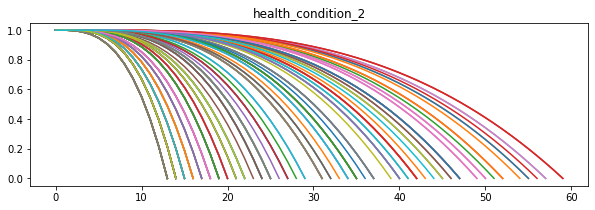

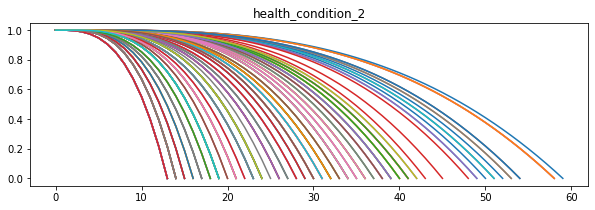

In [21]:
plot_samples(train_1day, ['health_condition_2'], 150, figsize=(10, 3))
plot_samples(val_1day, ['health_condition_2'], 150, figsize=(10, 3))

In [22]:
## selecting features for training
features = train_1day.columns.drop(['set_RfrErrorCode', 'Timestep',
                                   'Unit', 'error_code_53', 'health_condition_2','set_AssetId', 'Timestamp'])
features = features[~features.str.contains('list_|set_', regex=True)]

In [23]:
features.values

array(['stdev_1', 'max_1', 'min_1', 'avg_1', 'percentile_1_50',
       'percentile_1_95', 'stdev_2', 'max_2', 'min_2', 'avg_2',
       'percentile_2_50', 'percentile_2_95', 'stdev_7', 'max_7', 'min_7',
       'avg_7', 'percentile_7_50', 'percentile_7_95', 'stdev_15',
       'max_15', 'min_15', 'avg_15', 'percentile_15_50',
       'percentile_15_95', 'stdev_16', 'max_16', 'min_16', 'avg_16',
       'percentile_16_50', 'percentile_16_95', 'stdev_17', 'max_17',
       'min_17', 'avg_17', 'percentile_17_50', 'percentile_17_95',
       'stdev_64', 'avg_64', 'percentile_64_50', 'percentile_64_95',
       'max_64', 'min_64', 'stdev_66', 'max_66', 'min_66', 'avg_66',
       'percentile_66_50', 'percentile_66_95', 'stdev_117', 'max_117',
       'min_117', 'avg_117', 'percentile_117_50', 'percentile_117_95',
       'event_count', 'max_3_1', 'min_3_1', 'avg_3_1', 'stdev_3_1',
       'max_7_1', 'min_7_1', 'avg_7_1', 'stdev_7_1', 'max_14_1',
       'min_14_1', 'avg_14_1', 'stdev_14_1', 'max_3_2', '

## 12 hours

In [24]:
%%time
train_12hours = normalized_data(train_12hours) ## normalized and fill data 
val_12hours = normalized_data(val_12hours)
val_same_12hours = normalized_data(val_same_12hours)

Wall time: 1min 17s


In [25]:
health_condition_interpolate(train_12hours, n_first, n_last)
health_condition_interpolate(val_12hours, n_first, n_last)
health_condition_interpolate(val_same_12hours, n_first, n_last)

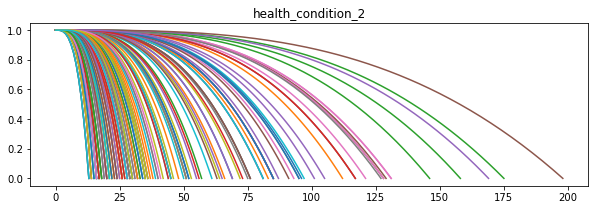

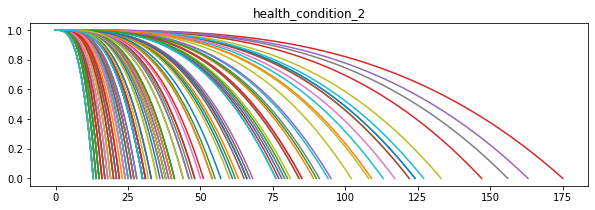

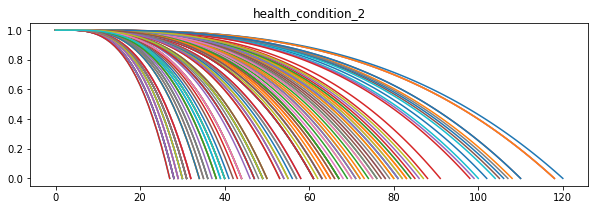

In [26]:
plot_samples(train_12hours, ['health_condition_2'], 150, figsize=(10, 3))
plot_samples(val_12hours, ['health_condition_2'], 150, figsize=(10, 3))
plot_samples(val_same_12hours, ['health_condition_2'], 150, figsize=(10, 3))

## Training model

remove unit 1 each Asset Id, split test by last Unit each AssetId and use 0.2 length head and tail each unit to evalute

In [27]:
%%time
study_1day = optuna.create_study(direction="maximize", study_name="LGBM Regressor")
func_1day = lambda trial: objective_custom(trial, train_1day, features, target_col = 'health_condition_2', split=0.2,
                                          min_unit_size= 14, max_unit_size = 60)
study_1day.optimize(func_1day, n_trials=25)

[I 2022-11-07 22:03:23,429] A new study created in memory with name: LGBM Regressor
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=1.1553312442478536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1553312442478536
[LightGBM] [Warning] lambda_l1 is set=0.007612790873718719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007612790873718719
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.119255889500861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.119255889500861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:06:08,121] Trial 0 finished with value: 0.4015867958351186 and parameters: {'n_estimators': 15000, 'learning_rate': 0.020745848534627673, 'num_leaves': 1380, 'max_depth': 20, 'min_data_in_leaf': 6500, 'max_bin': 221, 'lambda_l1': 0.007612790873718719, 'lambda_l2': 9.119255889500861, 'min_gain_to_split': 1.1553312442478536, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.4015867958351186.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=0.7225463782351726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7225463782351726
[LightGBM] [Warning] lambda_l1 is set=4.748369686379332e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.748369686379332e-08
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=8.335239069624077e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.335239069624077e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-11-07 22:06:48,351] Trial 1 finished with value: 0.40947073420223734 and parameters: {'n_estimators': 7000, 'learning_rate': 0.14624662122128512, 'num_leaves': 4440, 'max_depth': 32, 'min_data_in_leaf': 6300, 'max_bin': 279, 'lambda_l1': 4.748369686379332e-08, 'lambda_l2': 8.335239069624077e-07, 'min_gain_to_split': 0.7225463782351726, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=13.509548809774971, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.509548809774971
[LightGBM] [Warning] lambda_l1 is set=8.526921860191617e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.526921860191617e-07
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.00017019150238953905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017019150238953905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:08:59,463] Trial 2 finished with value: 0.2792754283317762 and parameters: {'n_estimators': 20000, 'learning_rate': 0.1169548709901632, 'num_leaves': 3920, 'max_depth': 22, 'min_data_in_leaf': 8900, 'max_bin': 280, 'lambda_l1': 8.526921860191617e-07, 'lambda_l2': 0.00017019150238953905, 'min_gain_to_split': 13.509548809774971, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=0.8436207465178047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8436207465178047
[LightGBM] [Warning] lambda_l1 is set=8.00380476029879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.00380476029879
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=7.3846153848958994e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3846153848958994e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:10:12,906] Trial 3 finished with value: 0.3899730489456944 and parameters: {'n_estimators': 20000, 'learning_rate': 0.03616792094476336, 'num_leaves': 1640, 'max_depth': 33, 'min_data_in_leaf': 6100, 'max_bin': 209, 'lambda_l1': 8.00380476029879, 'lambda_l2': 7.3846153848958994e-06, 'min_gain_to_split': 0.8436207465178047, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=2.8731842283662425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8731842283662425
[LightGBM] [Warning] lambda_l1 is set=0.0005620281734093808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005620281734093808
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.3341237042715436e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3341237042715436e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:13:21,093] Trial 4 finished with value: 0.37100043030084395 and parameters: {'n_estimators': 20000, 'learning_rate': 0.015914297839525388, 'num_leaves': 3980, 'max_depth': 30, 'min_data_in_leaf': 9800, 'max_bin': 219, 'lambda_l1': 0.0005620281734093808, 'lambda_l2': 4.3341237042715436e-07, 'min_gain_to_split': 2.8731842283662425, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=3.0672855211064047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0672855211064047
[LightGBM] [Warning] lambda_l1 is set=3.0515150929638364e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0515150929638364e-05
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.602352805556487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.602352805556487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_fr

[I 2022-11-07 22:14:45,622] Trial 5 finished with value: 0.3565491702052841 and parameters: {'n_estimators': 20000, 'learning_rate': 0.14081659253267303, 'num_leaves': 2400, 'max_depth': 46, 'min_data_in_leaf': 7400, 'max_bin': 226, 'lambda_l1': 3.0515150929638364e-05, 'lambda_l2': 9.602352805556487, 'min_gain_to_split': 3.0672855211064047, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=12.924549094434623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.924549094434623
[LightGBM] [Warning] lambda_l1 is set=5.92850083534904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.92850083534904e-07
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.769408120275824e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.769408120275824e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-07 22:15:42,781] Trial 6 finished with value: 0.30114883940141357 and parameters: {'n_estimators': 7000, 'learning_rate': 0.13156683184379972, 'num_leaves': 2140, 'max_depth': 25, 'min_data_in_leaf': 2700, 'max_bin': 201, 'lambda_l1': 5.92850083534904e-07, 'lambda_l2': 3.769408120275824e-08, 'min_gain_to_split': 12.924549094434623, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=4.679415343219179, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.679415343219179
[LightGBM] [Warning] lambda_l1 is set=9.743735683074299e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.743735683074299e-08
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.9144280200761306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9144280200761306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:16:41,514] Trial 7 finished with value: 0.35210535961206246 and parameters: {'n_estimators': 7000, 'learning_rate': 0.17120915588661903, 'num_leaves': 2000, 'max_depth': 43, 'min_data_in_leaf': 8800, 'max_bin': 200, 'lambda_l1': 9.743735683074299e-08, 'lambda_l2': 0.9144280200761306, 'min_gain_to_split': 4.679415343219179, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=11.616979434960006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.616979434960006
[LightGBM] [Warning] lambda_l1 is set=3.7263919138988356e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7263919138988356e-06
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.019307083026097675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019307083026097675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:18:39,808] Trial 8 finished with value: 0.27921024516979187 and parameters: {'n_estimators': 15000, 'learning_rate': 0.08105051823369007, 'num_leaves': 620, 'max_depth': 49, 'min_data_in_leaf': 8800, 'max_bin': 202, 'lambda_l1': 3.7263919138988356e-06, 'lambda_l2': 0.019307083026097675, 'min_gain_to_split': 11.616979434960006, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=13.374653939650932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.374653939650932
[LightGBM] [Warning] lambda_l1 is set=1.6938215383462828e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6938215383462828e-08
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.000743863447060441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000743863447060441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:20:48,762] Trial 9 finished with value: 0.30450457483619653 and parameters: {'n_estimators': 20000, 'learning_rate': 0.152889811872991, 'num_leaves': 4900, 'max_depth': 33, 'min_data_in_leaf': 7900, 'max_bin': 255, 'lambda_l1': 1.6938215383462828e-08, 'lambda_l2': 0.000743863447060441, 'min_gain_to_split': 13.374653939650932, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=7.43119989841346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.43119989841346
[LightGBM] [Warning] lambda_l1 is set=0.07186087497886437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07186087497886437
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=5.658470549962729e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.658470549962729e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq

[I 2022-11-07 22:21:34,100] Trial 10 finished with value: 0.28069574203773506 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07234629344642886, 'num_leaves': 3340, 'max_depth': 10, 'min_data_in_leaf': 3600, 'max_bin': 298, 'lambda_l1': 0.07186087497886437, 'lambda_l2': 5.658470549962729e-06, 'min_gain_to_split': 7.43119989841346, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.40947073420223734.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5072892730543987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5072892730543987
[LightGBM] [Warning] lambda_l1 is set=0.0026235077215442004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0026235077215442004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.02274429776904698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02274429776904698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:23:03,449] Trial 11 finished with value: 0.44274630130528037 and parameters: {'n_estimators': 15000, 'learning_rate': 0.08089397111008856, 'num_leaves': 720, 'max_depth': 15, 'min_data_in_leaf': 200, 'max_bin': 251, 'lambda_l1': 0.0026235077215442004, 'lambda_l2': 0.02274429776904698, 'min_gain_to_split': 0.5072892730543987, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.72361321498397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.72361321498397
[LightGBM] [Warning] lambda_l1 is set=0.000336918071080628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000336918071080628
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.019032053143973614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019032053143973614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

[I 2022-11-07 22:23:45,661] Trial 12 finished with value: 0.33498845996381255 and parameters: {'n_estimators': 7000, 'learning_rate': 0.1893767802945907, 'num_leaves': 300, 'max_depth': 15, 'min_data_in_leaf': 200, 'max_bin': 259, 'lambda_l1': 0.000336918071080628, 'lambda_l2': 0.019032053143973614, 'min_gain_to_split': 6.72361321498397, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=9.849414045895513, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.849414045895513
[LightGBM] [Warning] lambda_l1 is set=0.05626283657608359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05626283657608359
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.007929309165098113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007929309165098113
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_fr

[I 2022-11-07 22:25:01,562] Trial 13 finished with value: 0.28835738104019915 and parameters: {'n_estimators': 15000, 'learning_rate': 0.09048538544165442, 'num_leaves': 4940, 'max_depth': 40, 'min_data_in_leaf': 4600, 'max_bin': 272, 'lambda_l1': 0.05626283657608359, 'lambda_l2': 0.007929309165098113, 'min_gain_to_split': 9.849414045895513, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.40589963704874266, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40589963704874266
[LightGBM] [Warning] lambda_l1 is set=2.4518554910418957e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4518554910418957e-05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1.3475403485955158e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3475403485955158e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:26:02,843] Trial 14 finished with value: 0.43862465956522934 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05325626187513928, 'num_leaves': 1000, 'max_depth': 38, 'min_data_in_leaf': 500, 'max_bin': 241, 'lambda_l1': 2.4518554910418957e-05, 'lambda_l2': 1.3475403485955158e-08, 'min_gain_to_split': 0.40589963704874266, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.048837340968794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.048837340968794
[LightGBM] [Warning] lambda_l1 is set=4.537113156880254e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.537113156880254e-05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.2239942931975636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2239942931975636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq

[I 2022-11-07 22:27:12,519] Trial 15 finished with value: 0.33464342092732957 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0541068347056645, 'num_leaves': 860, 'max_depth': 38, 'min_data_in_leaf': 600, 'max_bin': 241, 'lambda_l1': 4.537113156880254e-05, 'lambda_l2': 0.2239942931975636, 'min_gain_to_split': 5.048837340968794, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=2.854402987972187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.854402987972187
[LightGBM] [Warning] lambda_l1 is set=0.004646305274788288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004646305274788288
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1.204418011336998e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.204418011336998e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_

[I 2022-11-07 22:28:13,221] Trial 16 finished with value: 0.3708907629199891 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0558296996591198, 'num_leaves': 1040, 'max_depth': 11, 'min_data_in_leaf': 1500, 'max_bin': 241, 'lambda_l1': 0.004646305274788288, 'lambda_l2': 1.204418011336998e-08, 'min_gain_to_split': 2.854402987972187, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=9.463699403420168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.463699403420168
[LightGBM] [Warning] lambda_l1 is set=5.375392397736011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.375392397736011
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.00023457256894140145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023457256894140145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:29:25,242] Trial 17 finished with value: 0.31500246780437136 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0949461475587839, 'num_leaves': 2960, 'max_depth': 28, 'min_data_in_leaf': 2500, 'max_bin': 239, 'lambda_l1': 5.375392397736011, 'lambda_l2': 0.00023457256894140145, 'min_gain_to_split': 9.463699403420168, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=5.15871676904552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.15871676904552
[LightGBM] [Warning] lambda_l1 is set=3.639045365875591e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.639045365875591e-05
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.002674661402209283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002674661402209283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:30:41,577] Trial 18 finished with value: 0.33991277560046174 and parameters: {'n_estimators': 15000, 'learning_rate': 0.058085351884386925, 'num_leaves': 40, 'max_depth': 17, 'min_data_in_leaf': 1400, 'max_bin': 265, 'lambda_l1': 3.639045365875591e-05, 'lambda_l2': 0.002674661402209283, 'min_gain_to_split': 5.15871676904552, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.44274630130528037.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=0.11673778786546324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11673778786546324
[LightGBM] [Warning] lambda_l1 is set=0.4806311527557401, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4806311527557401
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1.6147044966039545e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6147044966039545e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-07 22:32:13,806] Trial 19 finished with value: 0.4434487262730318 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11596175645262757, 'num_leaves': 1260, 'max_depth': 37, 'min_data_in_leaf': 4100, 'max_bin': 231, 'lambda_l1': 0.4806311527557401, 'lambda_l2': 1.6147044966039545e-05, 'min_gain_to_split': 0.11673778786546324, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 19 with value: 0.4434487262730318.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=2.3751947639678797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3751947639678797
[LightGBM] [Warning] lambda_l1 is set=0.48998061210568805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48998061210568805
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=4.9424191940042575e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9424191940042575e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-07 22:33:32,347] Trial 20 finished with value: 0.37104699586886214 and parameters: {'n_estimators': 15000, 'learning_rate': 0.11019210728201595, 'num_leaves': 1600, 'max_depth': 25, 'min_data_in_leaf': 4400, 'max_bin': 231, 'lambda_l1': 0.48998061210568805, 'lambda_l2': 4.9424191940042575e-05, 'min_gain_to_split': 2.3751947639678797, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 19 with value: 0.4434487262730318.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.2931744169576097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2931744169576097
[LightGBM] [Warning] lambda_l1 is set=0.00821328134899721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00821328134899721
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1.5178030347863787e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5178030347863787e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:34:47,530] Trial 21 finished with value: 0.4463004870015751 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11798810721425912, 'num_leaves': 1160, 'max_depth': 38, 'min_data_in_leaf': 1500, 'max_bin': 249, 'lambda_l1': 0.00821328134899721, 'lambda_l2': 1.5178030347863787e-07, 'min_gain_to_split': 0.2931744169576097, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 21 with value: 0.4463004870015751.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.0828072942928697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0828072942928697
[LightGBM] [Warning] lambda_l1 is set=0.004888709705888247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004888709705888247
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1.0929954220003695e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0929954220003695e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-11-07 22:36:26,973] Trial 22 finished with value: 0.45210224529733 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11920310270543735, 'num_leaves': 680, 'max_depth': 36, 'min_data_in_leaf': 2200, 'max_bin': 249, 'lambda_l1': 0.004888709705888247, 'lambda_l2': 1.0929954220003695e-07, 'min_gain_to_split': 0.0828072942928697, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 22 with value: 0.45210224529733.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=2.0131113357827437, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0131113357827437
[LightGBM] [Warning] lambda_l1 is set=0.36378193198898123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36378193198898123
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1.3962203823524795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3962203823524795e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-07 22:37:17,574] Trial 23 finished with value: 0.3819496045976255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12300605888414597, 'num_leaves': 400, 'max_depth': 36, 'min_data_in_leaf': 3100, 'max_bin': 234, 'lambda_l1': 0.36378193198898123, 'lambda_l2': 1.3962203823524795e-07, 'min_gain_to_split': 2.0131113357827437, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 22 with value: 0.45210224529733.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1780
Train on: 12137 units
Validate on: 1780 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=4.092100591431186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.092100591431186
[LightGBM] [Warning] lambda_l1 is set=0.021368275156397748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021368275156397748
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=2.9872633966472843e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9872633966472843e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:37:58,872] Trial 24 finished with value: 0.3385619036876194 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16127833535972852, 'num_leaves': 1280, 'max_depth': 42, 'min_data_in_leaf': 1800, 'max_bin': 248, 'lambda_l1': 0.021368275156397748, 'lambda_l2': 2.9872633966472843e-06, 'min_gain_to_split': 4.092100591431186, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 22 with value: 0.45210224529733.


Wall time: 34min 35s


In [28]:
print(f"\tBest value (adj-r2): {study_1day.best_value:.5f}")
study_1day.best_params

	Best value (adj-r2): 0.45210


{'n_estimators': 10000,
 'learning_rate': 0.11920310270543735,
 'num_leaves': 680,
 'max_depth': 36,
 'min_data_in_leaf': 2200,
 'max_bin': 249,
 'lambda_l1': 0.004888709705888247,
 'lambda_l2': 1.0929954220003695e-07,
 'min_gain_to_split': 0.0828072942928697,
 'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.8}

In [29]:
%%time
reg_model_1day, fused_data_1day, val_fused_data_1day = train_and_fused(study_1day.best_params,
                                                                       train_1day,
                                                                       val_1day,
                                                                       features,
                                                                       target_col = 'health_condition_2')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.0828072942928697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0828072942928697
[LightGBM] [Warning] lambda_l1 is set=0.004888709705888247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004888709705888247
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1.0929954220003695e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0929954220003695e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
R2 score on train set:  0.757265097535826
R2 score on valida

In [30]:
pd.DataFrame([reg_model_1day.feature_importances_], columns=reg_model_1day.feature_name_).T.sort_values(0, ascending=False).reset_index()

index     0
0    normalized_14_17  7548
1    normalized_14_15  7032
2            max_14_1  5484
3            min_14_2  5085
4            max_14_2  4883
..                ...   ...
152  percentile_66_50    47
153            min_66     0
154         min_14_66     0
155          min_7_66     0
156          min_3_66     0

[157 rows x 2 columns]

In [31]:
data_exp_1day.set_AssetId.nunique()

2095

In [61]:
data_exp_1day[data_exp_1day.set_AssetId == data_exp_1day.set_AssetId.unique()[123]]

Timestamp  stdev_1  max_1  min_1   avg_1  percentile_1_50  \
53476 2018-11-23   0.2776    9.1    8.3   8.740             8.80   
53477 2018-11-24   0.0000    0.0    0.0   0.000             0.00   
53478 2018-11-25   0.0000    0.0    0.0   0.000             0.00   
53479 2018-11-26   0.0000    0.0    0.0   0.000             0.00   
53480 2018-11-27   2.5860   12.0    1.1   6.312             6.50   
...          ...      ...    ...    ...     ...              ...   
54370 2022-05-25   5.9020   21.6   -4.4  11.750            14.45   
54371 2022-05-26   6.1300   32.0   -2.5  11.836            13.60   
54372 2022-05-27   6.9530   28.5   -2.6   8.805             9.60   
54373 2022-05-28   2.4880   16.6    9.3  13.250            13.10   
54374 2022-05-29   4.6840   15.6   -2.9   9.780            10.80   

       percentile_1_95  stdev_2  max_2  min_2  ...  max_7_117  min_7_117  \
53476              9.1   0.2347    8.9    8.0  ...        NaN        NaN   
53477              0.0   0.0000    0.0    0.0  ...        NaN        NaN   
53478              0.0   0.0000    0.0    0.0  ...        NaN        NaN   
53479              0.0   0.0000    0.0    0.0  ...        NaN        NaN   
53480             11.4   2.9140   12.0   -0.6  ...        NaN        NaN   
...                ...      ...    ...    ...  ...        ...        ...   
54370             17.4   2.2900   18.9   10.4  ...        0.0        0.0   
54371             19.9   4.9700   20.7    1.6  ...        0.0        0.0   
54372             18.9   4.8700   19.4   -0.7  ...        0.0        0.0   
54373             16.5   2.6760   17.6    9.6  ...        0.0        0.0   
54374             14.9   2.8280   15.0    1.5  ...        0.0        0.0   

       avg_7_117   stdev_7_117  max_14_117  min_14_117  avg_14_117  \
53476        NaN           NaN         NaN         NaN         NaN   
53477        NaN           NaN         NaN         NaN         NaN   
53478        NaN           NaN         NaN         NaN         NaN   
53479        NaN           NaN         NaN         NaN         NaN   
53480        NaN           NaN         NaN         NaN         NaN   
...          ...           ...         ...         ...         ...   
54370        0.0  4.708846e-07         0.0         0.0         0.0   
54371        0.0  4.843478e-07         0.0         0.0         0.0   
54372        0.0  4.855632e-07         0.0         0.0         0.0   
54373        0.0  4.826614e-07         0.0         0.0         0.0   
54374        0.0  4.890157e-07         0.0         0.0         0.0   

       stdev_14_117  Unit Timestep  
53476           NaN  1995        1  
53477           NaN  1995        2  
53478           NaN  1995        3  
53479           NaN  1995        4  
53480           NaN  1995        5  
...             ...   ...      ...  
54370           0.0  2039        7  
54371           0.0  2039        8  
54372           0.0  2039        9  
54373           0.0  2039       10  
54374           0.0  2039       11  

[899 rows x 167 columns]

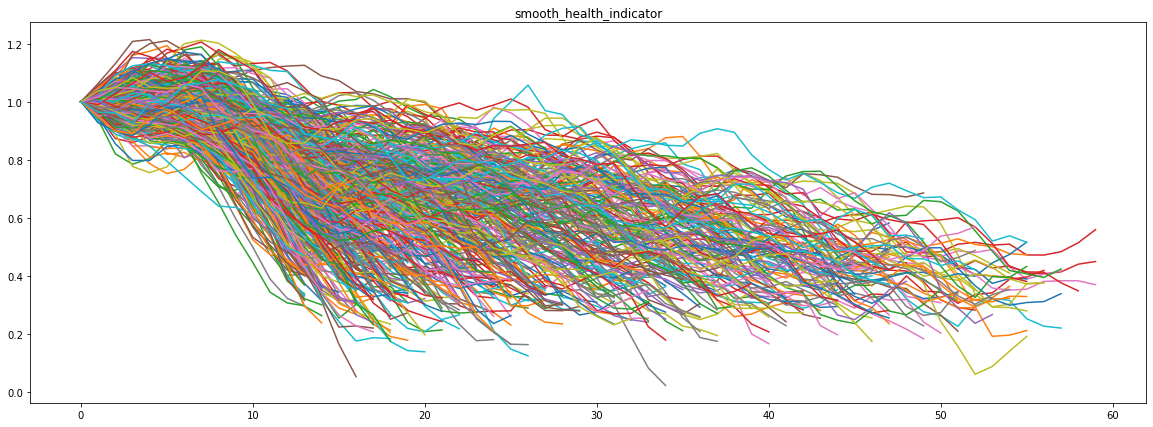

In [32]:
plot_samples(fused_data_1day, plot_cols=['smooth_health_indicator'], plot_units=500, figsize=(20, 7))

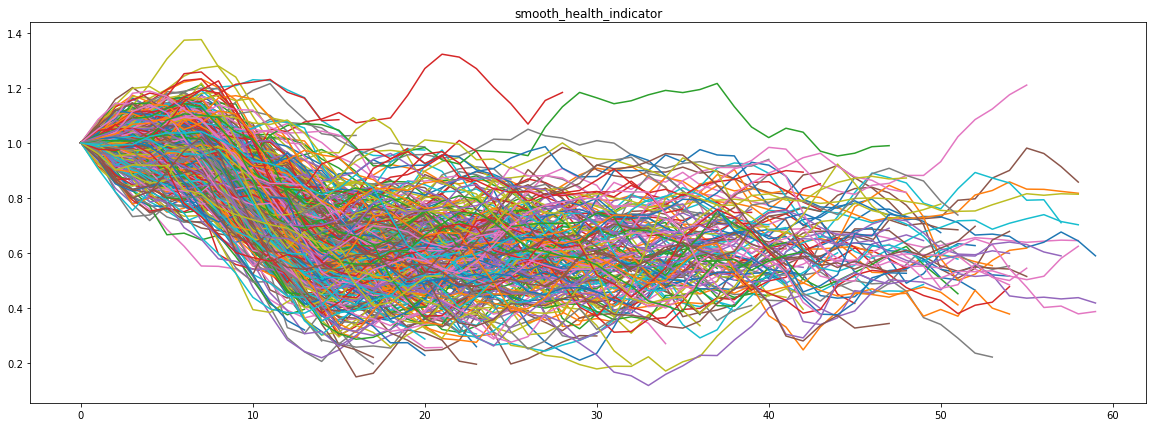

In [33]:
plot_samples(val_fused_data_1day, plot_cols=['smooth_health_indicator'], plot_units=500, figsize=(20, 7))

### 12 hours

In [34]:
%%time
study_12hours = optuna.create_study(direction="maximize", study_name = "LGBM Regressor")
func_12hours = lambda trial: objective_custom(trial, train_12hours, features, target_col = 'health_condition_2', split=0.2,
                                             min_unit_size = 14, max_unit_size = 200)
study_12hours.optimize(func_12hours, n_trials=25)

[I 2022-11-07 22:54:46,059] A new study created in memory with name: LGBM Regressor
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=4.973398182019836, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.973398182019836
[LightGBM] [Warning] lambda_l1 is set=7.168340568819696e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.168340568819696e-07
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=4.16260734767025e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.16260734767025e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 22:59:55,140] Trial 0 finished with value: 0.1387968888226132 and parameters: {'n_estimators': 15000, 'learning_rate': 0.024018067119472318, 'num_leaves': 1900, 'max_depth': 20, 'min_data_in_leaf': 1300, 'max_bin': 288, 'lambda_l1': 7.168340568819696e-07, 'lambda_l2': 4.16260734767025e-06, 'min_gain_to_split': 4.973398182019836, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.1387968888226132.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=3.4009985470817576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4009985470817576
[LightGBM] [Warning] lambda_l1 is set=1.7068640672819054e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7068640672819054e-06
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.839736271816407e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.839736271816407e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-11-07 23:05:23,884] Trial 1 finished with value: 0.1522408446772885 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09262309272345658, 'num_leaves': 780, 'max_depth': 14, 'min_data_in_leaf': 6200, 'max_bin': 200, 'lambda_l1': 1.7068640672819054e-06, 'lambda_l2': 2.839736271816407e-05, 'min_gain_to_split': 3.4009985470817576, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.1522408446772885.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] min_gain_to_split is set=11.61939497838841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.61939497838841
[LightGBM] [Warning] lambda_l1 is set=3.6434707274229085e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6434707274229085e-06
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1.2996984104378881e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2996984104378881e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:13:30,737] Trial 2 finished with value: 0.11279308103054986 and parameters: {'n_estimators': 20000, 'learning_rate': 0.07699617267518413, 'num_leaves': 2820, 'max_depth': 26, 'min_data_in_leaf': 4300, 'max_bin': 286, 'lambda_l1': 3.6434707274229085e-06, 'lambda_l2': 1.2996984104378881e-05, 'min_gain_to_split': 11.61939497838841, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.1522408446772885.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=14.450990857999335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.450990857999335
[LightGBM] [Warning] lambda_l1 is set=8.119195634538624e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.119195634538624e-05
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.7662134762100643e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7662134762100643e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:23:23,664] Trial 3 finished with value: 0.1191024753114659 and parameters: {'n_estimators': 15000, 'learning_rate': 0.08983902881518112, 'num_leaves': 2120, 'max_depth': 40, 'min_data_in_leaf': 5800, 'max_bin': 213, 'lambda_l1': 8.119195634538624e-05, 'lambda_l2': 1.7662134762100643e-05, 'min_gain_to_split': 14.450990857999335, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.1522408446772885.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=3.1163718700822205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1163718700822205
[LightGBM] [Warning] lambda_l1 is set=0.6993951130365694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6993951130365694
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.16507329109381355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16507329109381355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

[I 2022-11-07 23:33:48,346] Trial 4 finished with value: 0.1562645303372424 and parameters: {'n_estimators': 20000, 'learning_rate': 0.1169638891701428, 'num_leaves': 3140, 'max_depth': 37, 'min_data_in_leaf': 6100, 'max_bin': 218, 'lambda_l1': 0.6993951130365694, 'lambda_l2': 0.16507329109381355, 'min_gain_to_split': 3.1163718700822205, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 4 with value: 0.1562645303372424.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=8.391014817872918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.391014817872918
[LightGBM] [Warning] lambda_l1 is set=9.633925100162086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.633925100162086
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=2.0542309072258416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0542309072258416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:39:22,204] Trial 5 finished with value: 0.1164382283523222 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14242049389944433, 'num_leaves': 2600, 'max_depth': 22, 'min_data_in_leaf': 6600, 'max_bin': 271, 'lambda_l1': 9.633925100162086, 'lambda_l2': 2.0542309072258416, 'min_gain_to_split': 8.391014817872918, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 4 with value: 0.1562645303372424.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=8.53977542350791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.53977542350791
[LightGBM] [Warning] lambda_l1 is set=2.5219472998956718e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5219472998956718e-08
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.2352680595156926e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2352680595156926e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:45:55,030] Trial 6 finished with value: 0.1320757495790683 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04065351377679831, 'num_leaves': 760, 'max_depth': 36, 'min_data_in_leaf': 8800, 'max_bin': 243, 'lambda_l1': 2.5219472998956718e-08, 'lambda_l2': 1.2352680595156926e-06, 'min_gain_to_split': 8.53977542350791, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 4 with value: 0.1562645303372424.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=11.130147690976385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.130147690976385
[LightGBM] [Warning] lambda_l1 is set=0.00200667282112543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00200667282112543
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.30586133812478e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.30586133812478e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:49:21,092] Trial 7 finished with value: 0.11279496445960424 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19383376267372607, 'num_leaves': 4640, 'max_depth': 13, 'min_data_in_leaf': 6300, 'max_bin': 230, 'lambda_l1': 0.00200667282112543, 'lambda_l2': 9.30586133812478e-05, 'min_gain_to_split': 11.130147690976385, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 4 with value: 0.1562645303372424.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=8.170173078052759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.170173078052759
[LightGBM] [Warning] lambda_l1 is set=0.04436484816409959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04436484816409959
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=4.636848955902892e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.636848955902892e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 23:53:37,398] Trial 8 finished with value: 0.0966237288094377 and parameters: {'n_estimators': 20000, 'learning_rate': 0.030684049051780127, 'num_leaves': 4020, 'max_depth': 23, 'min_data_in_leaf': 6400, 'max_bin': 247, 'lambda_l1': 0.04436484816409959, 'lambda_l2': 4.636848955902892e-06, 'min_gain_to_split': 8.170173078052759, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 4 with value: 0.1562645303372424.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=3.653306320197533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.653306320197533
[LightGBM] [Warning] lambda_l1 is set=4.678362602760625e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.678362602760625e-07
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.4909011971526453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4909011971526453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:03:17,861] Trial 9 finished with value: 0.15747275180312903 and parameters: {'n_estimators': 20000, 'learning_rate': 0.17456346488221536, 'num_leaves': 1140, 'max_depth': 26, 'min_data_in_leaf': 6400, 'max_bin': 292, 'lambda_l1': 4.678362602760625e-07, 'lambda_l2': 0.4909011971526453, 'min_gain_to_split': 3.653306320197533, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 9 with value: 0.15747275180312903.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] min_gain_to_split is set=0.16195445775070194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.16195445775070194
[LightGBM] [Warning] lambda_l1 is set=3.1591770121224896e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1591770121224896e-08
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.0082015994829638, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0082015994829638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:08:57,693] Trial 10 finished with value: 0.19496574717603898 and parameters: {'n_estimators': 7000, 'learning_rate': 0.19674541393681472, 'num_leaves': 100, 'max_depth': 50, 'min_data_in_leaf': 9700, 'max_bin': 299, 'lambda_l1': 3.1591770121224896e-08, 'lambda_l2': 0.0082015994829638, 'min_gain_to_split': 0.16195445775070194, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.19496574717603898.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=0.28122673834901546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28122673834901546
[LightGBM] [Warning] lambda_l1 is set=1.3046141991069065e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3046141991069065e-08
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.01257905477942871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01257905477942871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:11:30,774] Trial 11 finished with value: 0.19709549383113845 and parameters: {'n_estimators': 7000, 'learning_rate': 0.19460611944599132, 'num_leaves': 100, 'max_depth': 47, 'min_data_in_leaf': 9200, 'max_bin': 300, 'lambda_l1': 1.3046141991069065e-08, 'lambda_l2': 0.01257905477942871, 'min_gain_to_split': 0.28122673834901546, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.19709549383113845.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.27445167955574684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27445167955574684
[LightGBM] [Warning] lambda_l1 is set=3.5866125003656345e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5866125003656345e-08
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.0046082374946577204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0046082374946577204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current val

[I 2022-11-08 00:16:07,866] Trial 12 finished with value: 0.19762017207761595 and parameters: {'n_estimators': 7000, 'learning_rate': 0.15519489579170836, 'num_leaves': 20, 'max_depth': 50, 'min_data_in_leaf': 10000, 'max_bin': 270, 'lambda_l1': 3.5866125003656345e-08, 'lambda_l2': 0.0046082374946577204, 'min_gain_to_split': 0.27445167955574684, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5916936103573178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5916936103573178
[LightGBM] [Warning] lambda_l1 is set=1.579198369855327e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.579198369855327e-08
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1.5002899299469428e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5002899299469428e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: 

[I 2022-11-08 00:19:34,210] Trial 13 finished with value: 0.18373902090552674 and parameters: {'n_estimators': 7000, 'learning_rate': 0.15241752189602956, 'num_leaves': 120, 'max_depth': 49, 'min_data_in_leaf': 8200, 'max_bin': 272, 'lambda_l1': 1.579198369855327e-08, 'lambda_l2': 1.5002899299469428e-08, 'min_gain_to_split': 0.5916936103573178, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=2.068734689829339, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.068734689829339
[LightGBM] [Warning] lambda_l1 is set=5.184224613121049e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.184224613121049e-05
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.0056703504969232476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056703504969232476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wi

[I 2022-11-08 00:23:16,349] Trial 14 finished with value: 0.1575072944989584 and parameters: {'n_estimators': 7000, 'learning_rate': 0.15825220299869885, 'num_leaves': 1580, 'max_depth': 44, 'min_data_in_leaf': 10000, 'max_bin': 267, 'lambda_l1': 5.184224613121049e-05, 'lambda_l2': 0.0056703504969232476, 'min_gain_to_split': 2.068734689829339, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=5.56465725222503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.56465725222503
[LightGBM] [Warning] lambda_l1 is set=1.4930991793627948e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4930991793627948e-07
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.0045925176553984065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0045925176553984065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-08 00:27:29,986] Trial 15 finished with value: 0.1234903049886854 and parameters: {'n_estimators': 7000, 'learning_rate': 0.1284276479511222, 'num_leaves': 20, 'max_depth': 44, 'min_data_in_leaf': 3700, 'max_bin': 261, 'lambda_l1': 1.4930991793627948e-07, 'lambda_l2': 0.0045925176553984065, 'min_gain_to_split': 5.56465725222503, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=1.645060116318759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.645060116318759
[LightGBM] [Warning] lambda_l1 is set=1.0398849729915025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0398849729915025e-05
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0008208354889115066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008208354889115066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-08 00:29:53,659] Trial 16 finished with value: 0.1703312408296752 and parameters: {'n_estimators': 7000, 'learning_rate': 0.17298689719395047, 'num_leaves': 1140, 'max_depth': 44, 'min_data_in_leaf': 8100, 'max_bin': 279, 'lambda_l1': 1.0398849729915025e-05, 'lambda_l2': 0.0008208354889115066, 'min_gain_to_split': 1.645060116318759, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] min_gain_to_split is set=6.034118266724716, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.034118266724716
[LightGBM] [Warning] lambda_l1 is set=0.0016833270396937382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016833270396937382
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.08902606164685788, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08902606164685788
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_

[I 2022-11-08 00:33:28,591] Trial 17 finished with value: 0.10416531919019678 and parameters: {'n_estimators': 7000, 'learning_rate': 0.17529870026858674, 'num_leaves': 3560, 'max_depth': 35, 'min_data_in_leaf': 7800, 'max_bin': 259, 'lambda_l1': 0.0016833270396937382, 'lambda_l2': 0.08902606164685788, 'min_gain_to_split': 6.034118266724716, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 12 with value: 0.19762017207761595.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.1122238678469003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1122238678469003
[LightGBM] [Warning] lambda_l1 is set=8.626244791447456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.626244791447456e-08
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=7.767679611363956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.767679611363956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:40:41,832] Trial 18 finished with value: 0.2025001127256656 and parameters: {'n_estimators': 7000, 'learning_rate': 0.1334981730528529, 'num_leaves': 660, 'max_depth': 32, 'min_data_in_leaf': 700, 'max_bin': 299, 'lambda_l1': 8.626244791447456e-08, 'lambda_l2': 7.767679611363956, 'min_gain_to_split': 0.1122238678469003, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.7223673739781984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7223673739781984
[LightGBM] [Warning] lambda_l1 is set=1.6184660438128922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6184660438128922e-05
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=7.633293629237432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.633293629237432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:43:12,595] Trial 19 finished with value: 0.16173659022694242 and parameters: {'n_estimators': 7000, 'learning_rate': 0.13124527191386887, 'num_leaves': 700, 'max_depth': 31, 'min_data_in_leaf': 400, 'max_bin': 278, 'lambda_l1': 1.6184660438128922e-05, 'lambda_l2': 7.633293629237432, 'min_gain_to_split': 2.7223673739781984, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=4.606786745214644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.606786745214644
[LightGBM] [Warning] lambda_l1 is set=0.0008654796038776919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008654796038776919
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=4.174644497135982e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.174644497135982e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-08 00:47:35,327] Trial 20 finished with value: 0.13203193421519033 and parameters: {'n_estimators': 15000, 'learning_rate': 0.06291481497736995, 'num_leaves': 1400, 'max_depth': 32, 'min_data_in_leaf': 2800, 'max_bin': 235, 'lambda_l1': 0.0008654796038776919, 'lambda_l2': 4.174644497135982e-07, 'min_gain_to_split': 4.606786745214644, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.10449014967441453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10449014967441453
[LightGBM] [Warning] lambda_l1 is set=1.186076460636024e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.186076460636024e-07
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.02559806757022701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02559806757022701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagg

[I 2022-11-08 00:55:41,567] Trial 21 finished with value: 0.19951905075317677 and parameters: {'n_estimators': 7000, 'learning_rate': 0.10907793845710921, 'num_leaves': 500, 'max_depth': 47, 'min_data_in_leaf': 1900, 'max_bin': 299, 'lambda_l1': 1.186076460636024e-07, 'lambda_l2': 0.02559806757022701, 'min_gain_to_split': 0.10449014967441453, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=1.497901153647718, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.497901153647718
[LightGBM] [Warning] lambda_l1 is set=1.5871509983618321e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5871509983618321e-07
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.0008103509290801436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008103509290801436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

[I 2022-11-08 01:00:04,824] Trial 22 finished with value: 0.16960900134515478 and parameters: {'n_estimators': 7000, 'learning_rate': 0.10709063154145752, 'num_leaves': 500, 'max_depth': 40, 'min_data_in_leaf': 2100, 'max_bin': 292, 'lambda_l1': 1.5871509983618321e-07, 'lambda_l2': 0.0008103509290801436, 'min_gain_to_split': 1.497901153647718, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.3397714420596027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3397714420596027
[LightGBM] [Warning] lambda_l1 is set=2.990632316447904e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.990632316447904e-07
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.052813790239496075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.052813790239496075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggin

[I 2022-11-08 01:04:03,089] Trial 23 finished with value: 0.174327543555563 and parameters: {'n_estimators': 7000, 'learning_rate': 0.11372684734111199, 'num_leaves': 520, 'max_depth': 46, 'min_data_in_leaf': 500, 'max_bin': 283, 'lambda_l1': 2.990632316447904e-07, 'lambda_l2': 0.052813790239496075, 'min_gain_to_split': 1.3397714420596027, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 18 with value: 0.2025001127256656.
C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\optuna\distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q


Numbers of vehicles:  1891
Train on: 25165 units
Validate on: 1891 units
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.2375313843596508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2375313843596508
[LightGBM] [Warning] lambda_l1 is set=9.577938644376867e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.577938644376867e-08
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.7218962669768498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7218962669768498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_

[I 2022-11-08 01:08:27,815] Trial 24 finished with value: 0.20748690618043297 and parameters: {'n_estimators': 7000, 'learning_rate': 0.13330629169809713, 'num_leaves': 1100, 'max_depth': 40, 'min_data_in_leaf': 1700, 'max_bin': 255, 'lambda_l1': 9.577938644376867e-08, 'lambda_l2': 0.7218962669768498, 'min_gain_to_split': 0.2375313843596508, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 24 with value: 0.20748690618043297.


Wall time: 2h 13min 41s


In [35]:
print(f"\tBest value (adj-r2): {study_12hours.best_value:.5f}")
study_12hours.best_params

	Best value (adj-r2): 0.20749


{'n_estimators': 7000,
 'learning_rate': 0.13330629169809713,
 'num_leaves': 1100,
 'max_depth': 40,
 'min_data_in_leaf': 1700,
 'max_bin': 255,
 'lambda_l1': 9.577938644376867e-08,
 'lambda_l2': 0.7218962669768498,
 'min_gain_to_split': 0.2375313843596508,
 'bagging_fraction': 0.30000000000000004,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

In [36]:
## test with val 12h period same time 1d period 
reg_model_same_12hours, fused_data_same_12hours, val_fused_data_same_12hours = train_and_fused(study_12hours.best_params,
                                                                               train_12hours,
                                                                               val_same_12hours,
                                                                               features,
                                                                               target_col='health_condition_2',
                                                                               window_size = 6)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.2375313843596508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2375313843596508
[LightGBM] [Warning] lambda_l1 is set=9.577938644376867e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.577938644376867e-08
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.7218962669768498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7218962669768498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
R2 score on train set:  0.41604387854808467
R2 score on validate s

In [37]:
## test with val 12h period  time 1d period 
reg_model_12hours, fused_data_12hours, val_fused_data_12hours = train_and_fused(study_12hours.best_params,
                                                                               train_12hours,
                                                                               val_12hours,
                                                                               features,
                                                                               target_col='health_condition_2',
                                                                               window_size = 6)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.2375313843596508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2375313843596508
[LightGBM] [Warning] lambda_l1 is set=9.577938644376867e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.577938644376867e-08
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.7218962669768498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7218962669768498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
R2 score on train set:  0.41604387854808467
R2 score on validate s

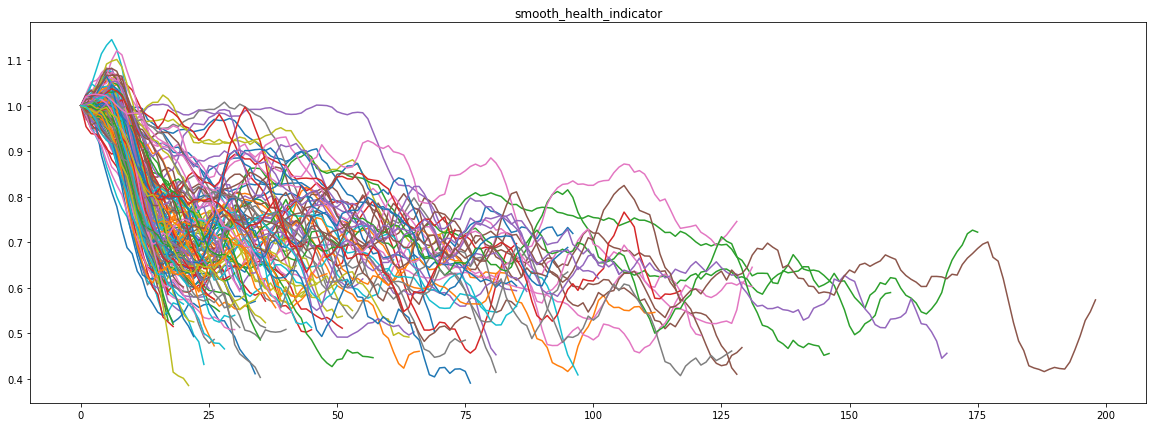

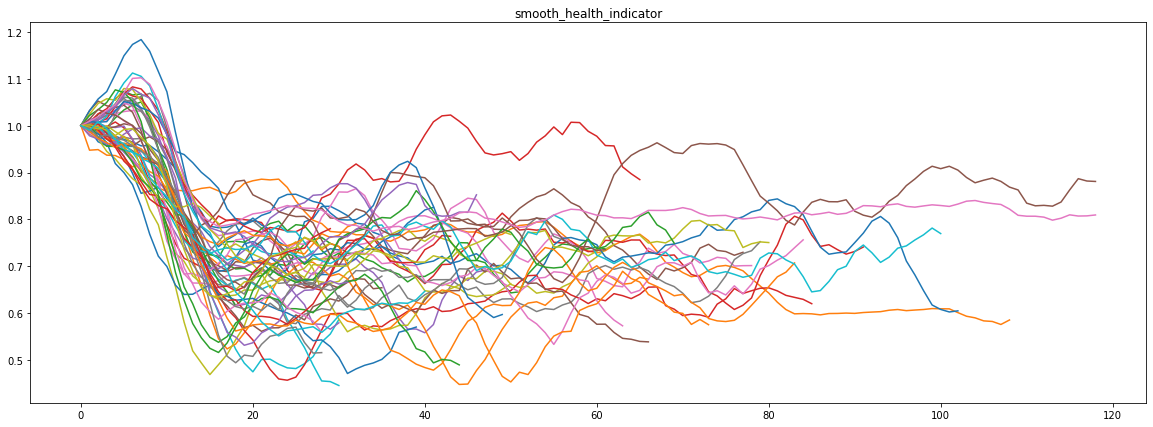

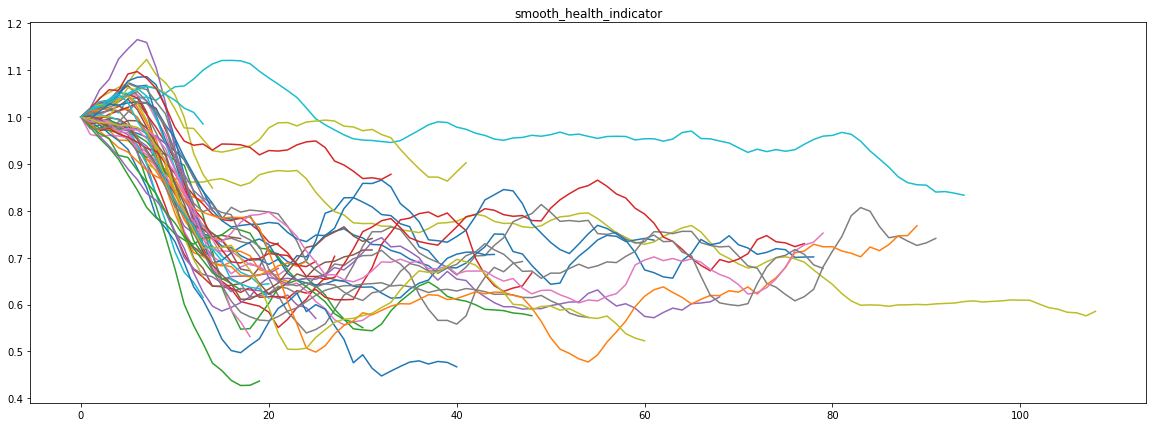

In [38]:
plot_samples(fused_data_same_12hours, plot_cols=['smooth_health_indicator'], plot_units=150, figsize=(20, 7))
plot_samples(val_fused_data_same_12hours, plot_cols=['smooth_health_indicator'], plot_units=50, figsize=(20, 7))
plot_samples(val_fused_data_12hours, plot_cols=['smooth_health_indicator'], plot_units=50, figsize=(20, 7))

## Evalutate

In [39]:
def evalutate_rul_regressor(train_fused_data, val_fused_data, hours=24, degree=4):
    # fit training health indicator line
    health_indicator = train_fused_data[['Unit', 'Time', 'smooth_health_indicator']].copy()
    reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
    
    # evaluate
    print('Start calculating loss')
    start_time = time.time()
    
    loss_df = get_loss_days(health_indicator, val_fused_data, reg_model_lib, degree, hours= hours, NEIGHBORS_NUM=50)
    end_time = time.time() - start_time
    print('Finished after: {} minutes'.format(end_time/60))
    return loss_df
loss_cols = ['Sample 50%', 'Sample 70%', 'Sample 90%']

In [40]:
def performance_report(loss_cols, loss_data, exact_range):
    report = []
    for col in loss_cols:
        true_col = f'True RUL {col}'
        pred_col = f'Pred RUL {col}'
        error_col = f'Sample {col}%'
        
        for loss_type in loss_data.type.unique():
            temp = loss_data[loss_data['type'] == loss_type] 
            
            mse_error = ((temp[error_col] ** 2 ).mean()).sum()
            median_error = temp[error_col].median()

            early_pred = (temp[pred_col] < abs(temp[true_col] - exact_range)).sum()
            exact_pred = temp[pred_col].between(temp[true_col] - exact_range, temp[true_col] + exact_range, inclusive='both').sum()
            late_pred = (temp[pred_col] > (temp[true_col] + exact_range)).sum()
            report.append([col, loss_type, mse_error, median_error, late_pred, early_pred, exact_pred, exact_range])
            
    report = pd.DataFrame(report, columns=['Sample length (%)', 'Model', 'MSE',
                                           'Median', 'Late pred', 'Early pred', 'Exact pred', 'Range'])
    return report

## 1 day period

In [41]:
loss_1day = evalutate_rul_regressor(fused_data_1day, val_fused_data_1day, hours=24, degree=4)

Start calculating loss
Finished after: 15.010203071435292 minutes


In [42]:
loss_1day['type'] = '1 day'

## 12 hours period

In [43]:
loss_12hours_same = evalutate_rul_regressor(fused_data_same_12hours, val_fused_data_same_12hours, hours=12, degree=4)

Start calculating loss
Finished after: 23.100180399417876 minutes


In [44]:
loss_12hours_same['type'] = '12 hours same'

In [45]:
loss_12hours = evalutate_rul_regressor(fused_data_12hours, val_fused_data_12hours, hours=12, degree=4)
loss_12hours['type'] = '12 hours'

Start calculating loss
Finished after: 141.63073621193567 minutes


In [46]:
#report_12hours = performance_report([50, 70, 90], loss_12hours, exact_range=4)

In [47]:
all_losses = pd.concat([loss_1day,loss_12hours_same, loss_12hours ])

In [48]:
all_losses

True RUL 50  Pred RUL 50  Sample 50%  True RUL 70  Pred RUL 70  \
0            10.0    35.423423   25.423423          6.0     8.960460   
1            27.0    22.857357    4.142643         17.0    14.469970   
2            16.0     5.296296   10.703704         10.0     1.063564   
3            23.0     2.452953   20.547047         14.0     3.594595   
4            12.0     6.130631    5.869369          8.0     3.126126   
...           ...          ...         ...          ...          ...   
8563          7.5     3.693944    3.806056          4.5     1.179179   
8564          6.5     2.334835    4.165165          4.0     0.516767   
8565         15.0     3.968969   11.031031          9.0     2.108358   
8566          9.0     1.735485    7.264515          5.5     3.175175   
8567          8.0     1.909409    6.090591          5.0     7.296046   

      Sample 70%  True RUL 90  Pred RUL 90  Sample 90%      type  
0       2.960460          2.0     5.175676    3.175676     1 day  
1       2.530030          6.0     6.228228    0.228228     1 day  
2       8.936436          4.0     1.337838    2.662162     1 day  
3      10.405405          5.0     8.301802    3.301802     1 day  
4       4.873874          3.0     0.385385    2.614615     1 day  
...          ...          ...          ...         ...       ...  
8563    3.320821          1.5     3.324825    1.824825  12 hours  
8564    3.483233          1.5     1.536036    0.036036  12 hours  
8565    6.891642          3.0     0.933433    2.066567  12 hours  
8566    2.324825          2.0     2.631882    0.631882  12 hours  
8567    2.296046          2.0     5.833333    3.833333  12 hours  

[12532 rows x 10 columns]

In [49]:
all_losses.to_csv('result/interpolated_condtion_loss_head_tail_split_update.csv', index=False)

In [50]:
report = performance_report([50, 70, 90], all_losses, exact_range=3)

In [51]:
report

Sample length (%)          Model         MSE    Median  Late pred  \
0                 50          1 day  144.016782  8.380881        459   
1                 50  12 hours same  150.254735  9.647898        133   
2                 50       12 hours  136.907178  6.452077       1101   
3                 70          1 day   63.051645  4.895896        452   
4                 70  12 hours same   84.527080  4.799550        431   
5                 70       12 hours   64.515624  3.366366       1444   
6                 90          1 day   51.710020  2.639640        856   
7                 90  12 hours same  170.614984  3.240741       1011   
8                 90       12 hours   87.915992  1.472973       2974   

   Early pred  Exact pred  Range  
0        1135         391      3  
1        1700         146      3  
2        5114        2353      3  
3         868         665      3  
4        1059         489      3  
5        3270        3854      3  
6          97        1106      3  
7          95         964      3  
8        1880        5564      3

Text(0.5, 1.0, 'MSE of different period')

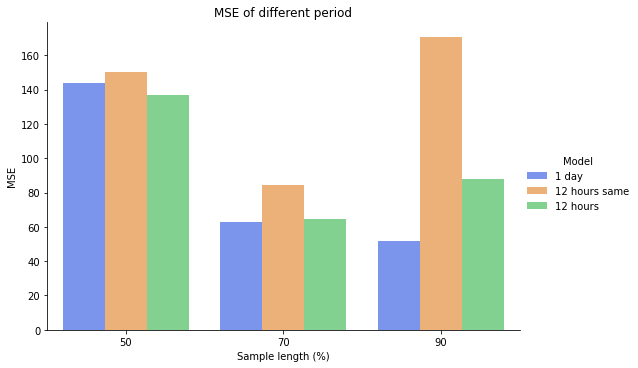

In [52]:
sns.catplot(data=report, kind='bar', x ='Sample length (%)', y='MSE', palette='bright', hue='Model',
            alpha=.6, height=5, aspect=1.5)
plt.title('MSE of different period')

Text(0.5, 1.0, 'Loss median of different period')

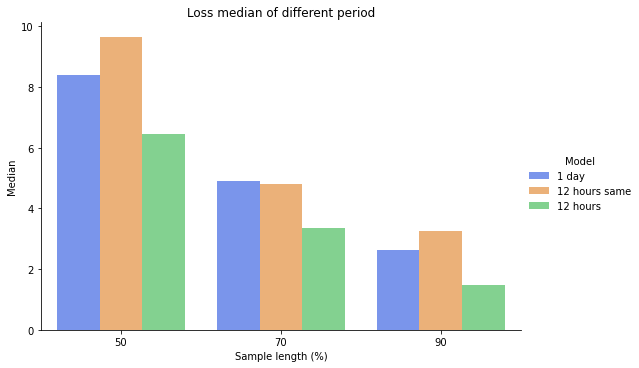

In [53]:
sns.catplot(data=report, kind="bar", x="Sample length (%)", y="Median", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Loss median of different period')

Text(0.5, 1.0, 'Exact prediction in 3 days range')

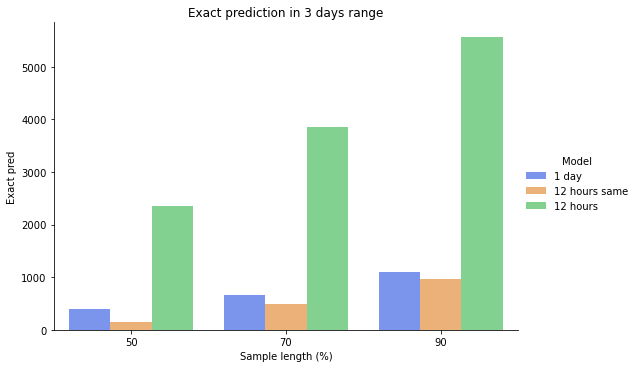

In [54]:
sns.catplot(data=report, kind="bar", x="Sample length (%)", y="Exact pred", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Exact prediction in 3 days range')

Text(0.5, 1.0, 'Late prediction in 3 days range')

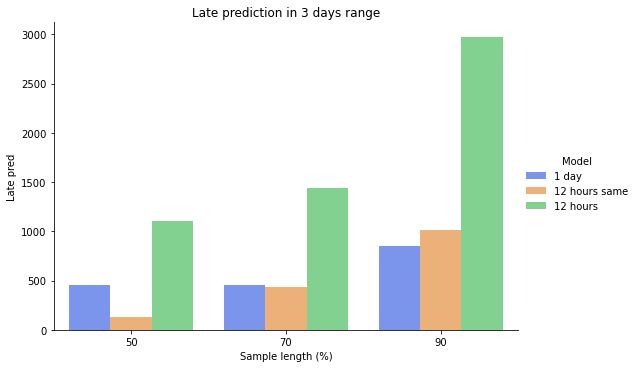

In [55]:
sns.catplot(data=report, kind="bar", x="Sample length (%)", y="Late pred", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Late prediction in 3 days range')

<AxesSubplot:>

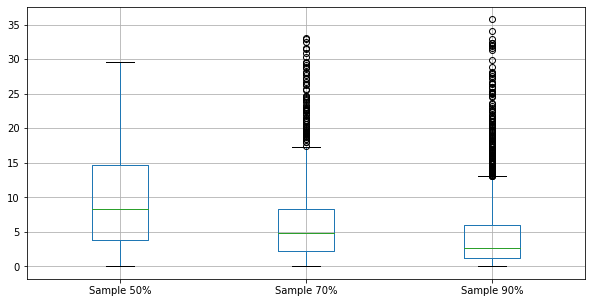

In [56]:
loss_1day[['Sample 50%', 'Sample 70%', 'Sample 90%']].boxplot(figsize=(10, 5))

<AxesSubplot:>

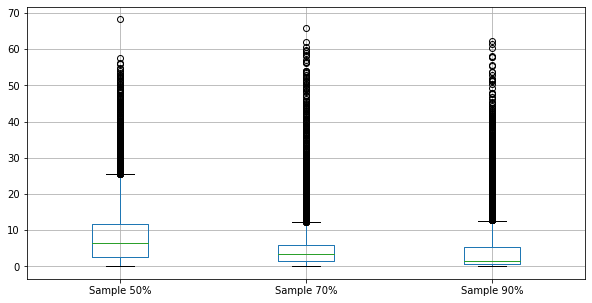

In [57]:
loss_12hours[['Sample 50%', 'Sample 70%', 'Sample 90%']].boxplot(figsize=(10, 5))

<AxesSubplot:>

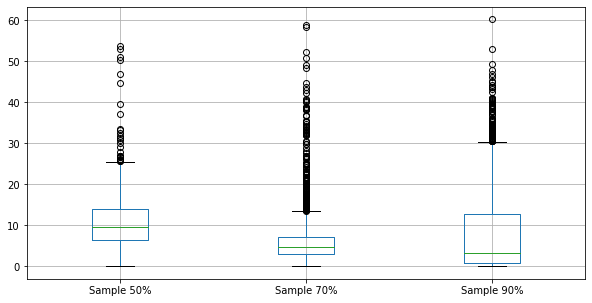

In [58]:
loss_12hours_same[['Sample 50%', 'Sample 70%', 'Sample 90%']].boxplot(figsize=(10, 5))

# get loss by week

In [191]:
def scoring_linear_reg_cus(train_data, unit_sample, reg_model_lib, sample_len, polynomial_deg=7):
    """
    This function calculate similarity score for each reg_model to 
    query sample
    Params:
        train_data (DataFrame): training data
        unit_sample (DataFrame): query unit to calculate similarity score
        reg_model_lib (dict): linear model of each training unit
        polynomial_deg (int): degree of polynomial line
    Return:
        scores_dict (dict): similarity score of each training unit to query unit
    """

    scores_dict = dict()

    # transform time steps (cycle) to polynomial feature 
    poly = PolynomialFeatures(polynomial_deg)
    time_steps = poly.fit_transform(np.arange(1, sample_len+1).reshape(-1, 1))
    time_steps = pd.DataFrame(time_steps)
    
    # select units with valid length only
    train_unit_sizes = train_data.groupby('Unit').size()
    pred_units = train_unit_sizes[train_unit_sizes >= sample_len].index.values

    # convert dict of reg models to dataframe
    model_params = []
    for unit in pred_units:
        reg_model = reg_model_lib[unit]
        model_params.append(reg_model.coef_.tolist() + [reg_model.intercept_]+[unit])
    model_params = pd.DataFrame(model_params)
    
    # renaming 
    model_params.rename(columns={model_params.columns[-1]: "Unit",
                                 model_params.columns[-2]: "intercept"},
                        inplace = True)
    
    # calculate distance and similarity score
    neighbors_line = time_steps.dot(model_params.iloc[:, :-2].T) + model_params['intercept']
    distance = unit_sample.iloc[:int(sample_len)]['smooth_health_indicator'].values - neighbors_line.T
    distance['Unit'] = model_params['Unit'].copy()

    distance['sim_score'] = np.exp(-np.linalg.norm(distance.T.iloc[:-1, :], ord=1, axis=0) ** 2)
    scores_dict = distance[['Unit', 'sim_score']].set_index('Unit')['sim_score'].to_dict()
    return scores_dict

In [192]:
def predict_days_bk(train_data, val_fused_data, cutpoint, reg_model_lib, hours=24, break_point=0, model='linear', NEIGHBORS_NUM=50, polynomial_deg=7):
    """
    This function return loss of a query sample predicted RUL from its neighbors
    Params:
        train_data (DataFrame): train data
        val_fused_data (DataFrame): validation data
        cutpoint (float): percentage of sample length to query
        reg_model_lib (dict): linear model of each training unit
        hours (int): number of hours data
        break_point (int): number of input observations to estimate RUL, this != 0 will ignore cutpoint
        NEIGHBORS_NUM (int): Numbers of neighbor to estimate RUL
        polynomial_deg (int): polynomial degree 
    Return:
        losses (list): loss value list of each query sample
    """

    losses = []
    labels = []
    predict_results = []
    day_rate = 24/hours
    
    # go through each query unit
    for unit in tqdm(val_fused_data['Unit'].unique()):
        unit_sample = val_fused_data[val_fused_data['Unit'] == unit][['Time', 'smooth_health_indicator']]

        true_RUL_point = int(len(unit_sample) * cutpoint)
        
        if break_point != 0:
            true_RUL_point = break_point * day_rate

        true_RUL = len(unit_sample) - true_RUL_point
        true_RUL /= day_rate
        
        try:
            if model == 'linear':
                scores_dict = scoring_linear_reg_cus(train_data, unit_sample, reg_model_lib, sample_len=true_RUL_point, polynomial_deg=polynomial_deg)
            else:
                scores_dict = scoring(train_data, unit_sample, reg_model_lib, sample_len=true_RUL_point, polynomial_deg=polynomial_deg)


            # sort similarity score asc
            sorted_scores = dict(sorted(scores_dict.items(), key=lambda item: item[1], reverse=True))
            selected_units = list(sorted_scores.keys())[:NEIGHBORS_NUM]  # get top nearest neighbors

            predict_RUL = estimate_rul(selected_units, train_data, true_RUL_point)
            predict_RUL /= day_rate

            losses.append(abs(predict_RUL - true_RUL))
            labels.append(true_RUL)
            predict_results.append(predict_RUL)
        except:
            losses.append(None)
            labels.append(None)
            predict_results.append(None)
            print('error unit: ',unit,'and length of Unit :',len(unit_sample))

    return losses, labels, predict_results

In [193]:
def get_loss_week(train_data, val_fused_data, reg_model_lib, polynomial_deg, NEIGHBORS_NUM, hours=24):
    """
    This function return experimental loss of current modeled health-indicator line.
    The result consists of different losses from 3 input sequence lengths - 50%, 70% and 90% length of input
    Params:
        train_data (DataFrame): train data
        val_fused_data (DataFrame): validation data
        reg_model_lib (dict): linear model of each training unit
        polynomial_deg (int): polynomial degree of modeled health-indicator
    Return:
        loss_df (DataFrame): loss value list of each query sample
    """
    
    # get losses
    loss_7, labels_7, pred_7 = predict_days_bk(train_data, val_fused_data, 1, reg_model_lib, model='linear',
                                                  break_point=7, hours = hours, NEIGHBORS_NUM=NEIGHBORS_NUM, polynomial_deg=polynomial_deg)
    loss_14, labels_14, pred_14 = predict_days_bk(train_data, val_fused_data, 1, reg_model_lib, model='linear',
                                                  break_point=14, hours = hours, NEIGHBORS_NUM=NEIGHBORS_NUM, polynomial_deg=polynomial_deg)
   

    loss_df = pd.DataFrame()
    loss_df['True RUL 7'] = labels_7
    loss_df['Pred RUL 7'] = pred_7
    loss_df['Sample 7 days'] = loss_7

    loss_df['True RUL 14'] = labels_14
    loss_df['Pred RUL 14'] = pred_14
    loss_df['Sample 14 days'] = loss_14
    return loss_df

In [194]:
def evalutate_rul_regressor_week(train_fused_data, val_fused_data, hours=24, degree=4):
    # fit training health indicator line
    health_indicator = train_fused_data[['Unit', 'Time', 'smooth_health_indicator']].copy()
    reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
    
    # evaluate
    print('Start calculating loss')
    start_time = time.time()
    
    loss_df = get_loss_week(health_indicator, val_fused_data, reg_model_lib, degree, hours= hours, NEIGHBORS_NUM=50)
    end_time = time.time() - start_time
    print('Finished after: {} minutes'.format(end_time/60))
    return loss_df

In [211]:
def performance_report_cus(loss_cols, loss_data, exact_range):
    report = []
    for col in loss_cols:
        true_col = f'True RUL {col}'
        pred_col = f'Pred RUL {col}'
        error_col = f'Sample {col} days'
        
        for loss_type in loss_data.type.unique():
            temp = loss_data[loss_data['type'] == loss_type] 
            
            mse_error = ((temp[error_col] ** 2 ).mean()).sum()
            median_error = temp[error_col].median()

            early_pred = (temp[pred_col] < abs(temp[true_col] - exact_range)).sum()
            exact_pred = temp[pred_col].between(temp[true_col] - exact_range, temp[true_col] + exact_range, inclusive='both').sum()
            late_pred = (temp[pred_col] > (temp[true_col] + exact_range)).sum()
            report.append([col, loss_type, mse_error, median_error, late_pred, early_pred, exact_pred, exact_range])
            
    report = pd.DataFrame(report, columns=['Sample days', 'Model', 'MSE',
                                           'Median', 'Late pred', 'Early pred', 'Exact pred', 'Range'])
    return report

In [ ]:
loss_week_1day = evalutate_rul_regressor_week(fused_data_1day, val_fused_data_1day, hours=24, degree=4)

In [ ]:
loss_week_1day['type'] = '1 day'

In [ ]:
val_fused_data_1day.groupby('Unit').size().sort_values()

## 12 hours

In [196]:
loss_week_12hours_same = evalutate_rul_regressor_week(fused_data_same_12hours, val_fused_data_same_12hours, hours=12, degree=4)

Start calculating loss


  0%|          | 0/1979 [00:00<?, ?it/s]

  0%|          | 0/1979 [00:00<?, ?it/s]

error unit:  7681 and length of Unit : 27
error unit:  22376 and length of Unit : 27
error unit:  28012 and length of Unit : 27
error unit:  36749 and length of Unit : 26
Finished after: 27.305079503854117 minutes


In [197]:
loss_week_12hours = evalutate_rul_regressor_week(fused_data_12hours, val_fused_data_12hours, hours=12, degree=4)

Start calculating loss


  0%|          | 0/8568 [00:00<?, ?it/s]

error unit:  2012 and length of Unit : 16
error unit:  2072 and length of Unit : 71
error unit:  2098 and length of Unit : 25
error unit:  2099 and length of Unit : 141
error unit:  2100 and length of Unit : 126
error unit:  2101 and length of Unit : 43
error unit:  2102 and length of Unit : 43
error unit:  2117 and length of Unit : 56
error unit:  2118 and length of Unit : 41
error unit:  2147 and length of Unit : 40
error unit:  2148 and length of Unit : 15
error unit:  2149 and length of Unit : 20
error unit:  2150 and length of Unit : 33
error unit:  2181 and length of Unit : 18
error unit:  2182 and length of Unit : 22
error unit:  2183 and length of Unit : 34
error unit:  2184 and length of Unit : 14
error unit:  2185 and length of Unit : 51
error unit:  2188 and length of Unit : 119
error unit:  2189 and length of Unit : 15
error unit:  2190 and length of Unit : 167
error unit:  2191 and length of Unit : 26
error unit:  2192 and length of Unit : 33
error unit:  2193 and length o

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



error unit: Traceback (most recent call last):
  File "C:\Windows\Temp\ipykernel_9352\3371969910.py", line 36, in predict_days_bk
    scores_dict = scoring_linear_reg_cus(train_data, unit_sample, reg_model_lib, sample_len=true_RUL_point, polynomial_deg=polynomial_deg)
  File "C:\Windows\Temp\ipykernel_9352\1644954314.py", line 29, in scoring_linear_reg_cus
    model_params.append(reg_model.coef_.tolist() + [reg_model.intercept_]+[unit])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PC\miniconda3\envs\tritm\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Windows\Temp\ipykernel_9352\1540313214.py", line 1, in <module>
    loss_week_12hours = evalutate_rul_regressor_week(fused_data_12hours, val_fused_data_12hours, hours=12, degree=4)
  File "C:\Windows\Temp\ipykernel_9352\3351891656.py", line 10, in evalu

TypeError: object of type 'NoneType' has no len()

In [198]:
loss_week_12hours_same['type'] = '12 hours same'
#loss_week_12hours['type'] = '12 hours'

In [200]:
all_losses_week = pd.concat([loss_week_1day, loss_week_12hours_same])

In [212]:
report_cus = performance_report_cus([7, 14], all_losses_week, exact_range=3)

In [226]:
fused_data_1day.Unit.nunique()

15831

In [225]:
report_cus

Sample days          Model         MSE     Median  Late pred  Early pred  \
0            7          1 day  246.579280   8.752252        478        1093   
1            7  12 hours same  527.636278  16.566567         49        1862   
2           14          1 day  231.371632   8.189690        380        1211   
3           14  12 hours same  315.960328   9.956206        123        1489   

   Exact pred  Range  
0         414      3  
1          68      3  
2         472      3  
3         488      3

Text(0.5, 1.0, 'MSE of different period')

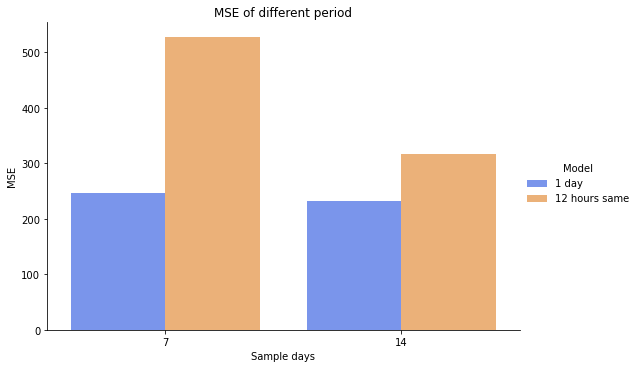

In [213]:
sns.catplot(data=report_cus, kind='bar', x ='Sample days', y='MSE', palette='bright', hue='Model',
            alpha=.6, height=5, aspect=1.5)
plt.title('MSE of different period')

Text(0.5, 1.0, 'Loss median of different period')

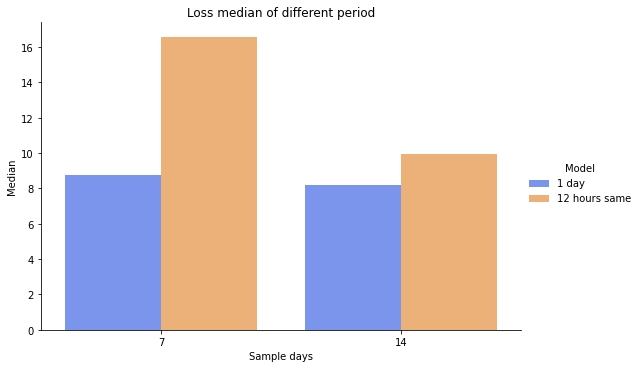

In [214]:
sns.catplot(data=report_cus, kind="bar", x="Sample days", y="Median", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Loss median of different period')

Text(0.5, 1.0, 'Exact prediction in 3 days range')

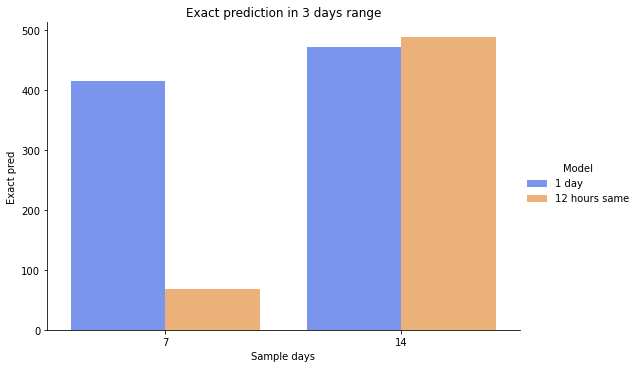

In [218]:
sns.catplot(data=report_cus, kind="bar", x="Sample days", y="Exact pred", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Exact prediction in 3 days range')

Text(0.5, 1.0, 'Late prediction in 3 days range')

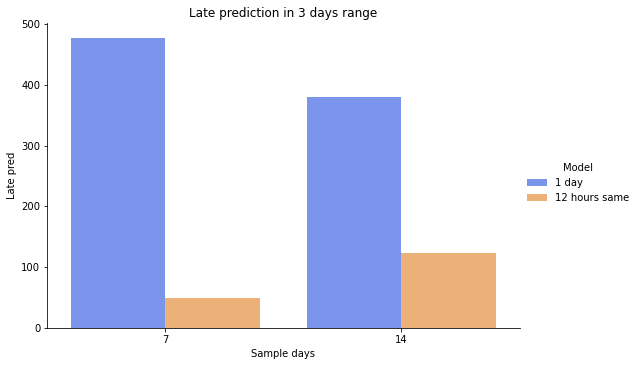

In [219]:
sns.catplot(data=report_cus, kind="bar", x="Sample days", y="Late pred", palette='bright', 
            hue="Model", alpha=.6, height=5, aspect=1.5)
plt.title('Late prediction in 3 days range')

<AxesSubplot:>

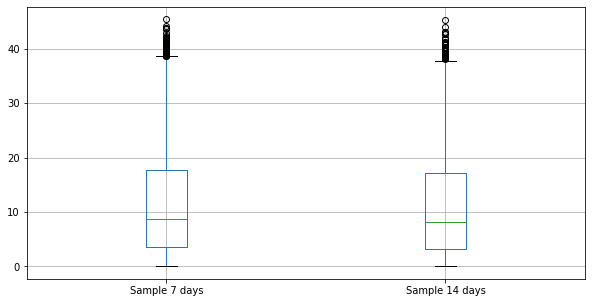

In [222]:
loss_week_1day[['Sample 7 days', 'Sample 14 days']].boxplot(figsize=(10, 5))

<AxesSubplot:>

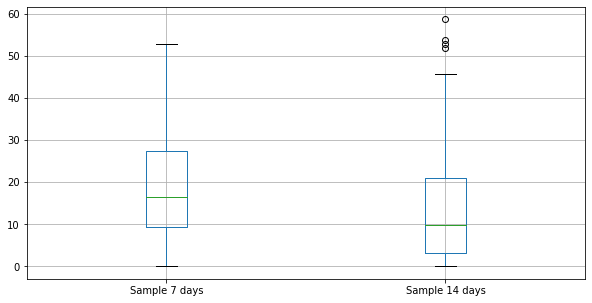

In [224]:
loss_week_12hours_same[['Sample 7 days', 'Sample 14 days']].boxplot(figsize=(10, 5))